In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import earthaccess
import joblib
import json
import pandas as pd
from shapely.geometry import shape
import xarray as xr

import helpers


/Users/aimeebarciauskas/github/ski-project/ski-project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load model
model = joblib.load('random_forest_model.pkl')

# Load scalers
X_scaler = joblib.load('X_scaler.pkl')
Y_scaler = joblib.load('Y_scaler.pkl')

In [3]:
with open('ski_areas.geojson', 'r') as f:
    ski_areas = json.load(f)


In [4]:
def is_wa_ski_site(area):
    return area['properties']['location'] and area['properties']['location']['iso3166_2'] == 'US-WA' and area['geometry']['type'] != 'Point'
wa_ski_sites = [area for area in ski_areas['features'] if is_wa_ski_site(area)]

len(wa_ski_sites)

17

In [5]:
crystal_mountain_area = [site for site in wa_ski_sites if site['properties']['name'] == 'Crystal Mountain'][0]
# crystal_mountain_area


In [6]:
# Alternative: Get bounds directly from shapely geometry
crystal_polygon = shape(crystal_mountain_area['geometry'])
crystal_bounds = crystal_polygon.bounds  # Returns (minx, miny, maxx, maxy)

print(f"\nDirect bounds: {crystal_bounds}")



Direct bounds: (-121.5089145, 46.90889530000001, -121.46718410000003, 46.9567407)


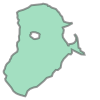

In [7]:
crystal_polygon

In [8]:
earthaccess.login()


In [9]:
def search_hls_data(args):
    """Function to search HLS data for a given year and collection"""
    year, hls_collection, crystal_bounds = args
    start_date, end_date = f'{year}-03-01', f'{year}-05-31'
    
    try:
        results = earthaccess.search_data(
            short_name=hls_collection,
            bounding_box=crystal_bounds,
            temporal=(start_date, end_date)
        )
        return results
    except Exception as e:
        print(f"Error searching {hls_collection} for {year}: {e}")
        return None

def process_hls_data(args):
    fs, granule, crystal_polygon, crystal_polygon_id = args
    hls_polygon_data = helpers.HlsPolygonMergedData(fs, granule, crystal_polygon, crystal_polygon_id)
    hls_polygon_data.process_hls_data()
    if hls_polygon_data.merged_dataset is not None:
        return hls_polygon_data.merged_dataset

def run_in_parallel(function, tasks):
    results = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        future_to_task = {executor.submit(function, task): task for task in tasks}
        for future in as_completed(future_to_task):
            result = future.result()
            if result is not None:
                results.append(result)
    return results



In [10]:

# Prepare arguments for all combinations
years = range(2015, 2026)
hls_collections = ['HLSL30', 'HLSS30']
tasks = [(year, collection, crystal_bounds) 
         for year in years 
         for collection in hls_collections]

hls_granules = [granule for search_result in run_in_parallel(search_hls_data, tasks) for granule in search_result]

In [11]:
crystal_polygon_id = crystal_mountain_area['properties']['name']
fs = earthaccess.get_fsspec_https_session()
tasks = [(fs, granule, crystal_polygon, crystal_polygon_id) for granule in hls_granules]

datasets = run_in_parallel(process_hls_data, tasks)



Processing polygon Crystal Mountain for date 2015-03-12T18:49:28.369Z
Processing 10 bands for merging...
Processing polygon Crystal Mountain for date 2015-03-19T18:55:37.598Z
Processing 10 bands for merging...
Processing polygon Crystal Mountain for date 2015-03-19T18:55:13.711Z
Processing 10 bands for merging...
Processing polygon Crystal Mountain for date 2015-03-12T18:49:28.369Z
Processing 10 bands for merging...
Processing polygon Crystal Mountain for date 2015-03-28T18:49:20.631Z
Processing 10 bands for merging...
No dataset returned
Processing polygon Crystal Mountain for date 2015-04-04T18:55:25.685Z
Processing 10 bands for merging...
Processing polygon Crystal Mountain for date 2015-04-04T18:55:01.798Z
Processing 10 bands for merging...
Processing polygon Crystal Mountain for date 2015-03-28T18:49:20.631Z
Processing 10 bands for merging...
No dataset returned
No dataset returned
Processing polygon Crystal Mountain for date 2015-04-13T18:49:15.298Z
Processing 10 bands for mergin

In [24]:
concated_dataset = xr.concat(datasets, dim='time', data_vars='all')

In [25]:
stacked = concated_dataset.stack(pixel=['y', 'x'])  

# Filter to only valid pixels
valid_pixels = stacked.where(stacked['Fmask'] != 255, drop=True)
input_df = valid_pixels.to_dataframe()
# TODO: why are there some rows with NaN values? A few thousand
input_df = input_df.dropna(subset=['B01'])
input_df


B01     B02     B03     B04  \
time                     y         x                                          
2015-03-19T18:55:13.711Z 5201445.0 614985.0  9338.0  9173.0  8751.0  8523.0   
                                   615015.0  9382.0  9196.0  8771.0  8558.0   
                                   615045.0  9398.0  9223.0  8806.0  8583.0   
                                   615075.0  9437.0  9257.0  8860.0  8623.0   
                         5201415.0 614835.0  9196.0  9094.0  8556.0  8364.0   
...                                             ...     ...     ...     ...   
2025-05-26T19:11:24.536Z 5196195.0 614385.0  5797.0  5543.0  5582.0  5428.0   
                                   614415.0  6115.0  5642.0  5641.0  5438.0   
                         5196165.0 614325.0  5617.0  5175.0  5223.0  5086.0   
                                   614355.0  5592.0  5363.0  5380.0  5199.0   
                                   614385.0  5592.0  5597.0  5619.0  5406.0   

                                                B05     B06     B07     B09  \
time                     y         x                                          
2015-03-19T18:55:13.711Z 5201445.0 614985.0  8309.0  2785.0  3240.0  3669.0   
                                   615015.0  8340.0  2814.0  3263.0  3699.0   
                                   615045.0  8363.0  2855.0  3310.0  3754.0   
                                   615075.0  8397.0  2943.0  3382.0  3885.0   
                         5201415.0 614835.0  8198.0  2600.0  3077.0  3420.0   
...                                             ...     ...     ...     ...   
2025-05-26T19:11:24.536Z 5196195.0 614385.0  5520.0  5633.0  5645.0  2248.0   
                                   614415.0  5569.0  5701.0  5666.0  2437.0   
                         5196165.0 614325.0  5190.0  5333.0  5338.0  2155.0   
                                   614355.0  5299.0  5399.0  5398.0  2126.0   
                                   614385.0  5464.0  5545.0  5529.0  2126.0   

                                                B10  Fmask     B08  \
time                     y         x                                 
2015-03-19T18:55:13.711Z 5201445.0 614985.0 -5260.0  194.0     NaN   
                                   615015.0 -5279.0  194.0     NaN   
                                   615045.0 -5286.0  194.0     NaN   
                                   615075.0 -5290.0  194.0     NaN   
                         5201415.0 614835.0 -5208.0  194.0     NaN   
...                                             ...    ...     ...   
2025-05-26T19:11:24.536Z 5196195.0 614385.0    55.0  194.0  5545.0   
                                   614415.0    56.0  194.0  5633.0   
                         5196165.0 614325.0    50.0  194.0  5209.0   
                                   614355.0    52.0  194.0  5366.0   
                                   614385.0    52.0  194.0  5578.0   

                                             spatial_ref          y         x  
time                     y         x                                           
2015-03-19T18:55:13.711Z 5201445.0 614985.0            0  5201445.0  614985.0  
                                   615015.0            0  5201445.0  615015.0  
                                   615045.0            0  5201445.0  615045.0  
                                   615075.0            0  5201445.0  615075.0  
                         5201415.0 614835.0            0  5201415.0  614835.0  
...                                                  ...        ...       ...  
2025-05-26T19:11:24.536Z 5196195.0 614385.0            0  5196195.0  614385.0  
                                   614415.0            0  5196195.0  614415.0  
                         5196165.0 614325.0            0  5196165.0  614325.0  
                                   614355.0            0  5196165.0  614355.0  
                                   614385.0            0  5196165.0  614385.0  

[2835758 rows x 14 columns]

In [38]:

import numpy as np
input_df['is_snow'] = input_df['Fmask'].apply(lambda x: 1 if int(x) & 16 > 0 else 0)
input_df['B08'] = input_df['B08'].fillna(np.nan)
input_df


B01     B02     B03  \
time                             y         x                                  
2015-03-19 18:55:13.711000+00:00 5201445.0 614985.0  9338.0  9173.0  8751.0   
                                           615015.0  9382.0  9196.0  8771.0   
                                           615045.0  9398.0  9223.0  8806.0   
                                           615075.0  9437.0  9257.0  8860.0   
                                 5201415.0 614835.0  9196.0  9094.0  8556.0   
...                                                     ...     ...     ...   
2025-05-26 19:11:24.536000+00:00 5196195.0 614385.0  5797.0  5543.0  5582.0   
                                           614415.0  6115.0  5642.0  5641.0   
                                 5196165.0 614325.0  5617.0  5175.0  5223.0   
                                           614355.0  5592.0  5363.0  5380.0   
                                           614385.0  5592.0  5597.0  5619.0   

                                                        B04     B05     B06  \
time                             y         x                                  
2015-03-19 18:55:13.711000+00:00 5201445.0 614985.0  8523.0  8309.0  2785.0   
                                           615015.0  8558.0  8340.0  2814.0   
                                           615045.0  8583.0  8363.0  2855.0   
                                           615075.0  8623.0  8397.0  2943.0   
                                 5201415.0 614835.0  8364.0  8198.0  2600.0   
...                                                     ...     ...     ...   
2025-05-26 19:11:24.536000+00:00 5196195.0 614385.0  5428.0  5520.0  5633.0   
                                           614415.0  5438.0  5569.0  5701.0   
                                 5196165.0 614325.0  5086.0  5190.0  5333.0   
                                           614355.0  5199.0  5299.0  5399.0   
                                           614385.0  5406.0  5464.0  5545.0   

                                                        B07     B09     B10  \
time                             y         x                                  
2015-03-19 18:55:13.711000+00:00 5201445.0 614985.0  3240.0  3669.0 -5260.0   
                                           615015.0  3263.0  3699.0 -5279.0   
                                           615045.0  3310.0  3754.0 -5286.0   
                                           615075.0  3382.0  3885.0 -5290.0   
                                 5201415.0 614835.0  3077.0  3420.0 -5208.0   
...                                                     ...     ...     ...   
2025-05-26 19:11:24.536000+00:00 5196195.0 614385.0  5645.0  2248.0    55.0   
                                           614415.0  5666.0  2437.0    56.0   
                                 5196165.0 614325.0  5338.0  2155.0    50.0   
                                           614355.0  5398.0  2126.0    52.0   
                                           614385.0  5529.0  2126.0    52.0   

                                                     Fmask     B08  \
time                             y         x                         
2015-03-19 18:55:13.711000+00:00 5201445.0 614985.0  194.0 -9999.0   
                                           615015.0  194.0 -9999.0   
                                           615045.0  194.0 -9999.0   
                                           615075.0  194.0 -9999.0   
                                 5201415.0 614835.0  194.0 -9999.0   
...                                                    ...     ...   
2025-05-26 19:11:24.536000+00:00 5196195.0 614385.0  194.0  5545.0   
                                           614415.0  194.0  5633.0   
                                 5196165.0 614325.0  194.0  5209.0   
                                           614355.0  194.0  5366.0   
                                           614385.0  194.0  5578.0   

                                                     spatial_

In [39]:

band_input_columns = [f"B{i:02d}" for i in range(1, 11)] + ["is_snow"]
x_input_data = input_df[band_input_columns]
x_scaled = X_scaler.transform(x_input_data)


In [40]:
y_pred = model.predict(x_scaled)
y_pred

array([0.28778481, 0.29708861, 0.31436709, ..., 0.50708861, 0.48848102,
       0.34544304], shape=(2835758,))

In [31]:
y_scaled = Y_scaler.inverse_transform([[pred] for pred in y_pred])
y_scaled

array([[45.46999979],
       [46.93999978],
       [49.66999969],
       ...,
       [80.12000022],
       [77.18000069],
       [54.58000052]], shape=(2835758, 1))

In [41]:
input_df['snow_depth_prediction'] = y_scaled

In [42]:
input_df.index = input_df.index.set_levels(pd.to_datetime(input_df.index.levels[0]), level=0)

In [43]:
# what we have a matrix of observations, identified by datetime and a snow depth prediction for each pixel.
# We can multiply those by the size of each pixel to get the area of snow.
# Then we can sum those up to get the total area of snow for each year.
area_of_each_pixel = 30 * 30
input_df['snow_volume_prediction'] = input_df['snow_depth_prediction'] * area_of_each_pixel
input_df['snow_volume_prediction']

time                              y          x       
2015-03-19 18:55:13.711000+00:00  5201445.0  614985.0    40922.999815
                                             615015.0    42245.999804
                                             615045.0    44702.999724
                                             615075.0    43847.999860
                                  5201415.0  614835.0    37322.999700
                                                             ...     
2025-05-26 19:11:24.536000+00:00  5196195.0  614385.0    46557.000492
                                             614415.0    44613.000497
                                  5196165.0  614325.0    72108.000200
                                             614355.0    69462.000620
                                             614385.0    49122.000467
Name: snow_volume_prediction, Length: 2835758, dtype: float64

In [44]:
volume_of_snow_for_hls_scene = input_df.groupby('time').agg({'snow_volume_prediction': 'sum'})

We can't aggregate over the year because each year had a different number of observations and the observations are on different days. 

But we can take the average for each year-month.

In [45]:
average_for_year_month = volume_of_snow_for_hls_scene.groupby([volume_of_snow_for_hls_scene.index.year, volume_of_snow_for_hls_scene.index.month]).agg({'snow_volume_prediction': 'sum'})
average_for_year_month

snow_volume_prediction
time time                        
2015 3               1.359197e+09
     4               2.006545e+09
     5               1.153742e+09
2016 3               1.844690e+09
     4               2.256281e+09
     5               2.428591e+09
2017 3               3.007695e+09
     4               2.518930e+09
     5               2.189601e+09
2018 3               5.767073e+09
     4               3.948049e+09
     5               3.811885e+09
2019 3               4.421830e+09
     4               4.097850e+09
     5               4.621747e+09
2020 3               4.440612e+09
     4               4.363246e+09
     5               4.121582e+09
2021 3               5.946783e+09
     4               5.748469e+09
     5               5.572645e+09
2022 3               7.326412e+09
     4               7.124610e+09
     5               7.430804e+09
2023 3               8.547753e+09
     4               8.097169e+09
     5               5.265677e+09
2024 3               6.031760e+09
     4               6.885412e+09
     5               6.031286e+09
2025 3               8.045559e+09
     4               7.902868e+09
     5               7.414357e+09

<Axes: xlabel='time,time'>

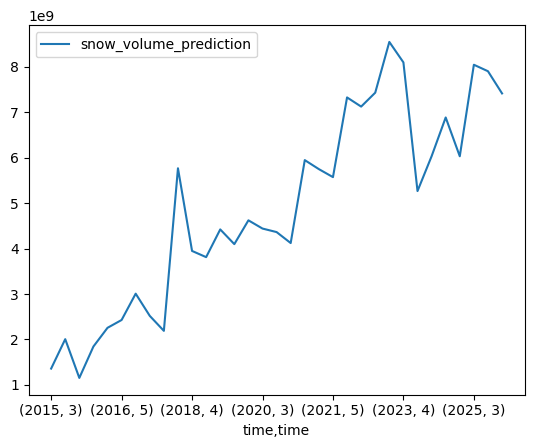

In [46]:
average_for_year_month.plot()